<h4>Transfer Learning</h4>

<h5>Imports</h5>

In [71]:
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse, unquote_plus
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import jsonlines
import os
import json
import pickle
from sklearn.metrics import f1_score, accuracy_score, precision_score
from typing import Callable
from sklearn import svm
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.python.profiler import profiler_v2 as profiler
import visualkeras
from PIL import ImageFont
import time
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve
import matplotlib.pyplot as plt
import math

In [33]:
file_names=['malicious','normal']
for name in file_names:
    data=[]
    with jsonlines.open('dataset/'+name+'.txt') as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data.append({'request':{'method':'POST', 'uri':line['request']['uri'], 'body':line['request']['body'],'headers':line['request']['headers']},'metadata':line['metdata']})
            else:
                data.append({'request':{'method':'GET', 'uri':line['request']['uri'], 'headers':line['request']['headers']},'metadata':line['metdata']})
    with jsonlines.open('dataset/'+name+'_clean.txt', mode='w') as writer:
        writer.write_all(data)
        
from collections import Counter


file_names = ['dataset/malicious_clean.txt' ,'dataset/normal_clean.txt']
data={}
for file in file_names:
    data[file]=[]
    with jsonlines.open(file) as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data[file].append('POST'+' '+line['request']['uri']+' '+line['request']['body']+' '+json.dumps(line['request']['headers']))
            else:
                data[file].append('GET'+' '+line['request']['uri']+' '+json.dumps(line['request']['headers']))

   
                
normal = data[file_names[1]]
malicious = data[file_names[0]]
normal_part1 = normal[180000:]
normal_part2 = normal[:180000]

train_examples = normal_part2
test_examples = normal_part1+malicious
train_labels = [0] * len(train_examples)
test_labels = [0]* len(normal_part1)
test_labels.extend([1] * len(malicious))



# add shuffled malicious data to train set
#malicious_shuffled = malicious.copy()  
#np.random.shuffle(malicious_shuffled)
#train_examples.extend(malicious_shuffled[:50000])
#train_labels.extend([1] * len(malicious_shuffled[:50000]))


dataset_train = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),train_examples)), train_labels))
dataset_test = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),test_examples)), test_labels))

#shuflee datasets with given radnom seed
dataset_train = dataset_train.shuffle(400000, seed=42, reshuffle_each_iteration=False)
dataset_test = dataset_test.shuffle(400000, seed=42, reshuffle_each_iteration=False)

def preprocess_text(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    text = tf.strings.regex_replace(text, '(.)',  r'\1 ')
    return text, label

def preprocess_text_substitution(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    punctuation = "=?/(){}[]<>"
    for p in punctuation:
        text = tf.strings.regex_replace(text, "\\" + p, " "+p+" ")
    return text, label

 
# Map the preprocess function to the dataset
train = dataset_train.map(preprocess_text)
test = dataset_test.map(preprocess_text)

train_sub = dataset_train.map(preprocess_text_substitution)
test_sub = dataset_test.map(preprocess_text_substitution)

for text, label in train_sub.take(1):
    print(text.numpy(), label.numpy())

for text, label in train.take(1):
    print(text.numpy(), label.numpy())



2023-06-06 19:43:26.105114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [180000]
	 [[{{node Placeholder/_1}}]]


b'a  / a / a  { "a-a": "a-a,a-a", "a": "a / a,a / a a,a / a;a = n.n,a / a,a / a,* / *;a = n.n", "a-a": "a;a = n.n, a;a = n.n, *;a = n.n", "a-a": "a / n.n  ( a a n.n; x; x )  a / n.n  ( a, a a )  a / n.n.n.n a / n.n a / n.n.n.n", "a": "a = x; a = x" } ' 0


2023-06-06 19:43:26.380897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [180000]
	 [[{{node Placeholder/_1}}]]


b'a   / a / a   { " a - a " :   " a - a , a - a " ,   " a " :   " a / a , a / a   a , a / a ; a = n . n , a / a , a / a , * / * ; a = n . n " ,   " a - a " :   " a ; a = n . n ,   a ; a = n . n ,   * ; a = n . n " ,   " a - a " :   " a / n . n   ( a   a   n . n ;   x ;   x )   a / n . n   ( a ,   a   a )   a / n . n . n . n   a / n . n   a / n . n . n . n " ,   " a " :   " a = x ;   a = x " } ' 0


<h4>Save and load vectorization from disk</h4>

In [ ]:

from_disk = pickle.load(open("vectorization.pkl", "rb"))
vectorization = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization.set_weights(from_disk['weights'])

from_disk_sub = pickle.load(open("vectorization_sub.pkl", "rb"))
vectorization_sub = TextVectorization.from_config(from_disk_sub['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization_sub.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization_sub.set_weights(from_disk_sub['weights'])

<h4>Load and retrain all models</h4>

In [ ]:
#load lstm model
lstm_model = tf.keras.models.load_model('lstm/my_model')
lstm_model_sub = tf.keras.models.load_model('lstm_sub/my_model')

#load transformer model
transformer_model = tf.keras.models.load_model('trans/my_model')
transformer_model_sub = tf.keras.models.load_model('trans_sub/my_model')

#load cnn model
cnn_model = tf.keras.models.load_model('cnn/my_model') 
cnn_model_sub = tf.keras.models.load_model('cnn_sub/my_model') 

#load autoencoder model
autoencoder_model = tf.keras.models.load_model('autoencoder/my_model')
autoencoder_model_sub = tf.keras.models.load_model('autoencoder_sub/my_model')

import pickle
filename = './svm/svm_model.sav'
svm_model = pickle.load(open(filename, 'rb'))

filename_sub = './svm_sub/svm_model.sav'
svm_model_sub = pickle.load(open(filename_sub, 'rb'))


In [53]:
#testdataset for normal_models:
def sub_processing(text, label):
    return  vectorization_sub(text), label

def processing(text, label):
    return  vectorization(text), label
test_auto_sub = test_sub.map(sub_processing)

test_auto = test.map(processing)



#tesdataset for svm
test_auto_svm = np.array(list(test_auto.as_numpy_iterator()))
test_auto_sub_svm = np.array(list(test_auto_sub.as_numpy_iterator()))
test_text = test_auto_svm[:,0]
test_label = test_auto_svm[:,1]
test_text_sub = test_auto_sub_svm[:,0]
test_label_sub = test_auto_sub_svm[:,1]


test_auto_sub = test_auto_sub.batch(32)
test_auto = test_auto.batch(32)
def get_data(x, y):
  return x

# Use the map() function to extract the labels
dataset_tmp = test_auto.map(get_data)
dataset_tmp_sub = test_auto_sub.map(get_data)

2023-06-07 00:49:05.358997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [117899]
	 [[{{node Placeholder/_0}}]]
/tmp/ipykernel_6549/3238461473.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_auto_svm = np.array(list(test_auto.as_numpy_iterator()))
2023-06-07 00:49:29.463953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dt

In [37]:
#run and time predictions
def predict_and_time(model,model_sub,name):
    print(f"Running predictions for {name}")
    start_time = time.time()
    reconstructions = model.predict(test_auto, verbose=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model predictions: {elapsed_time} seconds")
    start_time = time.time()
    reconstructions_sub = model_sub.predict(test_auto_sub, verbose=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model sub predictions: {elapsed_time} seconds")
    trainable_params = int(np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]))
    print("Suma trenowalnych parametrów:", trainable_params)
    trainable_params = int(np.sum([tf.keras.backend.count_params(w) for w in model_sub.trainable_weights]))
    print("Suma trenowalnych parametrów sub:", trainable_params)
    return reconstructions, reconstructions_sub
def predict_and_time_svm(model,model_sub):
    print(f"Running predictions for svm")
    start_time = time.time()
    reconstructions = model.predict(list(test_text))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model predictions: {elapsed_time} seconds")
    start_time = time.time()
    reconstructions_sub = model_sub.predict(list(test_text_sub))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model sub predictions: {elapsed_time} seconds")
    return reconstructions, reconstructions_sub    

reconstructions_cnn, reconstructions_sub_cnn = predict_and_time(cnn_model,cnn_model_sub,"cnn")
reconstructions_trans, reconstructions_sub_trans = predict_and_time(transformer_model,transformer_model_sub,"transformer")
reconstructions_lstm, reconstructions_sub_lstm = predict_and_time(lstm_model,lstm_model_sub,"lstm")
reconstructions_auto, reconstructions_sub_auto = predict_and_time(autoencoder_model,autoencoder_model_sub,"autoencoder")
reconstructions_svm, reconstructions_sub_svm = predict_and_time_svm(svm_model,svm_model_sub)

Running predictions for cnn


2023-06-06 19:44:46.424808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{node Placeholder/_9}}]]


Model predictions: 22.72735857963562 seconds


2023-06-06 19:45:09.144592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{node Placeholder/_9}}]]


Model sub predictions: 21.249239444732666 seconds
Suma trenowalnych parametrów: 192545
Suma trenowalnych parametrów sub: 160161
Running predictions for transformer
Model predictions: 22.944324016571045 seconds
Model sub predictions: 22.16677451133728 seconds
Suma trenowalnych parametrów: 71777
Suma trenowalnych parametrów sub: 67681
Running predictions for lstm
Model predictions: 49.38928747177124 seconds
Model sub predictions: 32.75259304046631 seconds
Suma trenowalnych parametrów: 620321
Suma trenowalnych parametrów sub: 604321
Running predictions for autoencoder
Model predictions: 22.603391885757446 seconds
Model sub predictions: 21.303611516952515 seconds
Suma trenowalnych parametrów: 148288
Suma trenowalnych parametrów sub: 37280
Running predictions for svm
Model predictions: 2187.1206471920013 seconds
Model sub predictions: 1154.9324202537537 seconds


In [38]:
import pickle

# Save the lists to disk
with open('reconstructions_cnn.pkl', 'wb') as f:
    pickle.dump(reconstructions_cnn, f)

with open('reconstructions_sub_cnn.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_cnn, f)

with open('reconstructions_trans.pkl', 'wb') as f:
    pickle.dump(reconstructions_trans, f)

with open('reconstructions_sub_trans.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_trans, f)

with open('reconstructions_lstm.pkl', 'wb') as f:
    pickle.dump(reconstructions_lstm, f)

with open('reconstructions_sub_lstm.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_lstm, f)

with open('reconstructions_auto.pkl', 'wb') as f:
    pickle.dump(reconstructions_auto, f)

with open('reconstructions_sub_auto.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_auto, f)

with open('reconstructions_svm.pkl', 'wb') as f:
    pickle.dump(reconstructions_svm, f)

with open('reconstructions_sub_svm.pkl', 'wb') as f:
    pickle.dump(reconstructions_sub_svm, f)



In [39]:
import pickle
# Load the lists from disk
with open('reconstructions_cnn.pkl', 'rb') as f:
    reconstructions_cnn = pickle.load(f)

with open('reconstructions_sub_cnn.pkl', 'rb') as f:
    reconstructions_sub_cnn = pickle.load(f)

with open('reconstructions_trans.pkl', 'rb') as f:
    reconstructions_trans = pickle.load(f)

with open('reconstructions_sub_trans.pkl', 'rb') as f:
    reconstructions_sub_trans = pickle.load(f)

with open('reconstructions_lstm.pkl', 'rb') as f:
    reconstructions_lstm = pickle.load(f)

with open('reconstructions_sub_lstm.pkl', 'rb') as f:
    reconstructions_sub_lstm = pickle.load(f)

with open('reconstructions_auto.pkl', 'rb') as f:
    reconstructions_auto = pickle.load(f)

with open('reconstructions_sub_auto.pkl', 'rb') as f:
    reconstructions_sub_auto = pickle.load(f)

with open('reconstructions_svm.pkl', 'rb') as f:
    reconstructions_svm = pickle.load(f)

with open('reconstructions_sub_svm.pkl', 'rb') as f:
    reconstructions_sub_svm = pickle.load(f)

tf.Tensor(11.465675, shape=(), dtype=float32)
Metrics for model auto
Accuracy: 0.8188449435533804
Precision: 0.8650380546593068
Recall: 0.8916209921320062
F1 Score: 0.8781283880171185
MCC: 0.5266118888793521


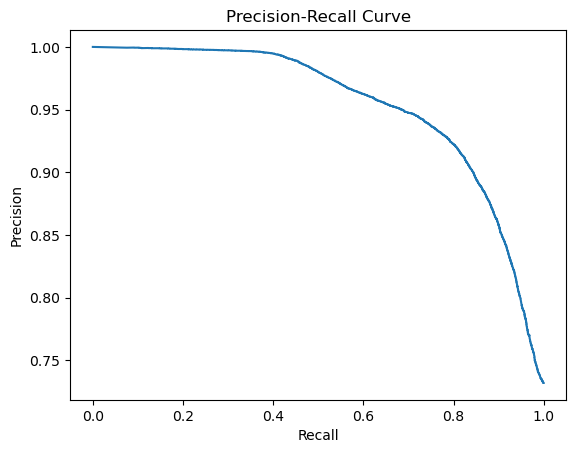

tf.Tensor(11.465675, shape=(), dtype=float32)
Metrics for model auto
Accuracy: 0.8067074360257509
Precision: 0.9201174820733998
Recall: 0.8058957809476356
F1 Score: 0.8592272292059179
MCC: 0.5677232758071605


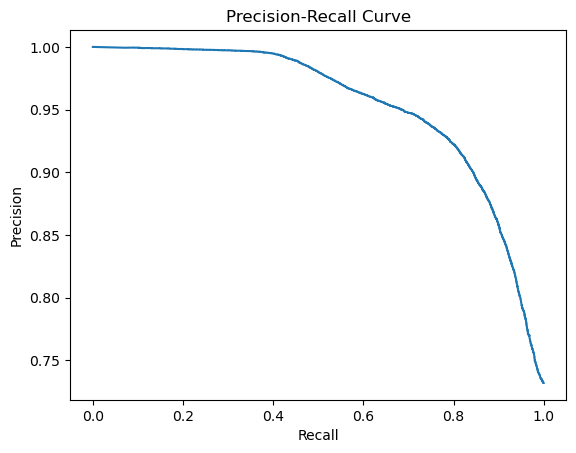

tf.Tensor(11.465675, shape=(), dtype=float32)


In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def calc_and_print_metrics(y_test,reconsturctions,name, mse_ratio=0.5):
    
    if(name.find("auto") != -1):
        if(name.find("sub") != -1):
            tmp_sub = np.concatenate(list(dataset_tmp_sub.as_numpy_iterator()))
            mse = tf.keras.losses.mean_squared_error(tmp_sub, reconsturctions)
        else:  
            tmp = np.concatenate(list(dataset_tmp.as_numpy_iterator()))
            mse = tf.keras.losses.mean_squared_error(tmp, reconsturctions)
        avg =  sum(mse) / len(mse)
        print(avg)
        reconsturctions=list(map(lambda x: sigmoid(x.numpy()-mse_ratio*avg.numpy()), list(mse)))
        y_pred = list(map(lambda x: 0 if sigmoid(x.numpy()-mse_ratio*avg.numpy())<0.5 else 1, list(mse)))
    elif(name.find("svm") != -1):
        y_pred = list(map(lambda x: 1 if x==-1 else 0, list(reconsturctions)))
    else:
        y_pred = list(map(lambda x: 0 if x[0]<0.5 else 1, list(reconsturctions)))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"Metrics for model {name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("MCC:", mcc)

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, reconsturctions)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

#actual = test_auto.map(lambda x,y:y)
#actual = np.concatenate(list(actual.as_numpy_iterator()))

#calc_and_print_metrics(actual,reconstructions_cnn,"cnn")
#calc_and_print_metrics(actual,reconstructions_sub_cnn,"cnn_sub")
#calc_and_print_metrics(actual,reconstructions_trans,"trans")
#calc_and_print_metrics(actual,reconstructions_sub_trans,"trans_sub")
#calc_and_print_metrics(actual,reconstructions_lstm,"lstm")
#calc_and_print_metrics(actual,reconstructions_sub_lstm,"lstm_sub")
calc_and_print_metrics(actual,reconstructions_auto,"auto",0.2)
calc_and_print_metrics(actual,reconstructions_auto,"auto",0.3)
calc_and_print_metrics(actual,reconstructions_auto,"auto",0.4)
#calc_and_print_metrics(actual,reconstructions_sub_auto,"auto_sub")
#calc_and_print_metrics(actual,reconstructions_svm,"svm")
#calc_and_print_metrics(actual,reconstructions_sub_svm,"svm_sub")

In [36]:
len(list(test_text))

117899

In [26]:
len(malicious)

25065